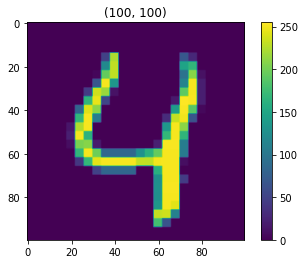

Elapsed (after compilation) = 0.8582229614257812


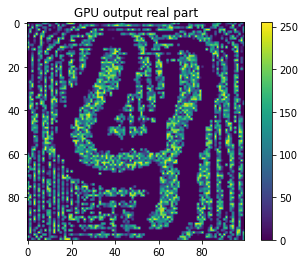

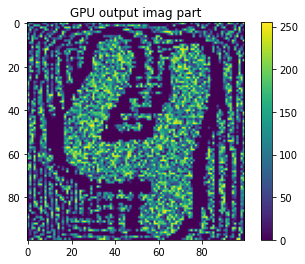

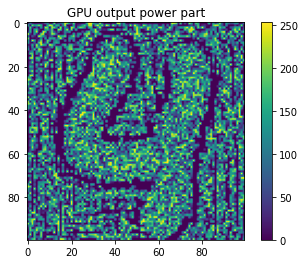

In [1]:
from numba import jit,njit,prange
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from numba import vectorize, cuda, float32
import imageio
import numba.types
import cmath


image=imageio.imread('4.png')

number4=np.ascontiguousarray(image[365:465,365:465])
#number4=np.random.rand(10,10)*255
plt.title(number4.shape)
plt.imshow(number4)
plt.colorbar()
plt.show()




@cuda.jit
def linear_prop(inp,out_real,out_imag,dis):
    x,y=cuda.grid(2)
    shape1,shape2=inp.shape

    
    wavelength=630e-9
    pitch=7.6e-6
    pi=3.1415936
    s=0
    
    s1=0
    s2=0
    for i in range(shape1):
        for j in range(shape2):
            i1=x-i
            j1=y-j
            s1+=math.cos(math.sqrt(math.pow(i1,2)+math.pow(j1,2)+math.pow(dis/pitch,2))*pitch/wavelength*2*pi)*inp[i,j]
            s2+=math.sin(math.sqrt(math.pow(i1,2)+math.pow(j1,2)+math.pow(dis/pitch,2))*pitch/wavelength*2*pi)*inp[i,j]
    cuda.syncthreads()  
    out_real[x,y] = s1
    out_imag[x,y] = s2
  
    
         
            

start = time.time()

distance=1e-2


size=100
TILE_DIM = 10
BLOCK_ROWS = 10

number4_cuda=cuda.to_device(number4)
output_real=np.zeros_like(number4)
output_imag=np.zeros_like(number4)
output_cuda_real=cuda.to_device(output_real)
output_cuda_imag=cuda.to_device(output_imag)

grid_shape = (int(size/TILE_DIM), int(size/TILE_DIM))

linear_prop[grid_shape,(TILE_DIM, BLOCK_ROWS)](number4_cuda,output_cuda_real,output_cuda_imag,distance)

end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

output0=output_cuda_real.copy_to_host()
plt.imshow(output0)
plt.title('GPU output real part')
plt.colorbar()
plt.show()

output1=output_cuda_imag.copy_to_host()
plt.imshow(output1)
plt.title('GPU output imag part')
plt.colorbar()
plt.show()

plt.imshow(output1**2+output0**2)
plt.title('GPU output power part')
plt.colorbar()
plt.show()

In [ ]:
holder.shape

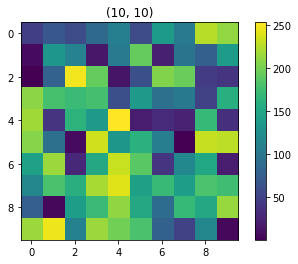

Elapsed (after compilation) = 0.6581261157989502


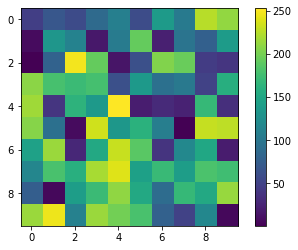

In [12]:
#shared memory speed up
from numba import jit,njit,prange
import numpy as np
import time
import matplotlib.pyplot as plt
import math
from numba import vectorize, cuda, float32
import imageio
import numba.types


#number4=imageio.imread('4.png')
number4=np.random.rand(10,10)*255
plt.title(number4.shape)
plt.imshow(number4)
plt.colorbar()
plt.show()


@cuda.jit
def linear_prop(inp,out,dis,wave,pitch):
    tile = cuda.shared.array((TILE_DIM, TILE_DIM), numba.types.float32)
    x = cuda.blockIdx.x * TILE_DIM + cuda.threadIdx.x
    y = cuda.blockIdx.y * TILE_DIM + cuda.threadIdx.y    
    for j in range(0, TILE_DIM, BLOCK_ROWS):
        tile[cuda.threadIdx.y + j, cuda.threadIdx.x] = inp[y + j, x] # move tile into shared memory
    cuda.syncthreads()    
    
    
    
    tmp=0
    for i in range(0, TILE_DIM, BLOCK_ROWS):
        tmp+= tile[cuda.threadIdx.y + i, cuda.threadIdx.x]
    cuda.syncthreads() 
    out[y,x]=tmp
    

            
            

start = time.time()

distance=1
wavelength=630e-9
pitch=7.6e-6

size=10
TILE_DIM = 2
BLOCK_ROWS = 2

number4_cuda=cuda.to_device(number4)
holder=np.zeros_like(number4)
holder_cuda=cuda.to_device(holder)


grid_shape = (int(size/TILE_DIM), int(size/TILE_DIM))

linear_prop[grid_shape,(TILE_DIM, BLOCK_ROWS)](number4_cuda,holder_cuda,distance,wavelength,pitch); cuda.synchronize()

end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

output=holder_cuda.copy_to_host()
plt.imshow(output)
plt.colorbar()
plt.show()